# Final Project for Unsupervised Learning

This project is based on a Kaggle competition of Disease Symptom Prediction and can be found here (https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset).  The original competition was designed to see if students could come up with a disease prediction score associated with symptoms.  Here, I am using the data a bit differently as to not come up with the same exact project.  My project here is to just do an unsupervised clustering of symptoms to see if there are general trends in disease and symptom correlation.

I will use a hierarchical clustering and some other dimensionality reduction techniques to put the patients with similar symptoms together and to see if the clustering of symptoms leads to unique disease groups.  Overall, the theroy is that patients with the exact same set of symptoms will separate from each other.  This in reality isn't practical, but we'll see how well the symptoms separate.

## Data Acquisition

In [94]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("itachi9604/disease-symptom-description-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\dvanbooven\.cache\kagglehub\datasets\itachi9604\disease-symptom-description-dataset\versions\2


In [97]:
# Import relevant libraries and then load in the dataset into data

import pandas as pd
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

data = pd.read_csv(os.path.join(path, "dataset.csv"))

print(data.head())

print(data.shape)

            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symp

Here we have 18 columns in total.  There is 1 disase column, and 17 symptom columns.  There are 4920 patients.

In [98]:
# Notice that the symptoms are spread across different columns.  Now take these columns and concatenate to get a single descriptor field

data['combined_symptoms'] = data['Symptom_1'] + " " + data['Symptom_2'] + " " + data['Symptom_3']

data['combined_symptoms'] = data.loc[:, 'Symptom_1':'Symptom_17'].apply(
    lambda row: ' '.join(row.dropna()), axis=1
)

print(data)

                                      Disease             Symptom_1  \
0                            Fungal infection               itching   
1                            Fungal infection             skin_rash   
2                            Fungal infection               itching   
3                            Fungal infection               itching   
4                            Fungal infection               itching   
...                                       ...                   ...   
4915  (vertigo) Paroymsal  Positional Vertigo              vomiting   
4916                                     Acne             skin_rash   
4917                  Urinary tract infection   burning_micturition   
4918                                Psoriasis             skin_rash   
4919                                 Impetigo             skin_rash   

                  Symptom_2              Symptom_3                  Symptom_4  \
0                 skin_rash   nodal_skin_eruptions        dischrom

Now the combined_symptoms column contains a concatenated version of all of the symptoms in symptom columns 1 through 17

In [99]:
# The 19th column should now have some sort of data in it.  For safety, let's check if it is still na, and if so remove it

# Now inspect any rows with an Na

rows_with_na = data[data['combined_symptoms'].isna()]

print(rows_with_na)



Empty DataFrame
Columns: [Disease, Symptom_1, Symptom_2, Symptom_3, Symptom_4, Symptom_5, Symptom_6, Symptom_7, Symptom_8, Symptom_9, Symptom_10, Symptom_11, Symptom_12, Symptom_13, Symptom_14, Symptom_15, Symptom_16, Symptom_17, combined_symptoms]
Index: []


This is an empty dataframe which means we have at least 1 symptom within each of the rows of the combined_symptoms column.  

In [100]:
#Let's look at the most and least frequent symptoms in the dataset.

from collections import Counter

# Step 1: Create the 'combined_symptoms' column if it doesn't exist
data['combined_symptoms'] = data.loc[:, 'Symptom_1':'Symptom_17'].apply(
    lambda row: ' '.join(row.dropna()), axis=1
)
all_symptoms = ' '.join(data['combined_symptoms'])
symptoms_list = all_symptoms.split()
symptom_counts = Counter(symptoms_list)
top_10_symptoms = symptom_counts.most_common(10)
print(top_10_symptoms)
lowest_10_symptoms = symptom_counts.most_common()[-10:]  # Slice to get the last 10 (least common)
print(lowest_10_symptoms)

[('fatigue', 1932), ('vomiting', 1914), ('high_fever', 1362), ('loss_of_appetite', 1152), ('nausea', 1146), ('headache', 1134), ('abdominal_pain', 1032), ('yellowish_skin', 912), ('yellowing_of_eyes', 816), ('chills', 798)]
[('dehydration', 108), ('weakness_in_limbs', 108), ('weakness_of_one_body_side', 108), ('swollen_blood_vessels', 108), ('spinning_movements', 108), ('pus_filled_pimples', 108), ('blackheads', 108), ('scurring', 108), ('foul_smell_of', 102), ('urine', 102)]


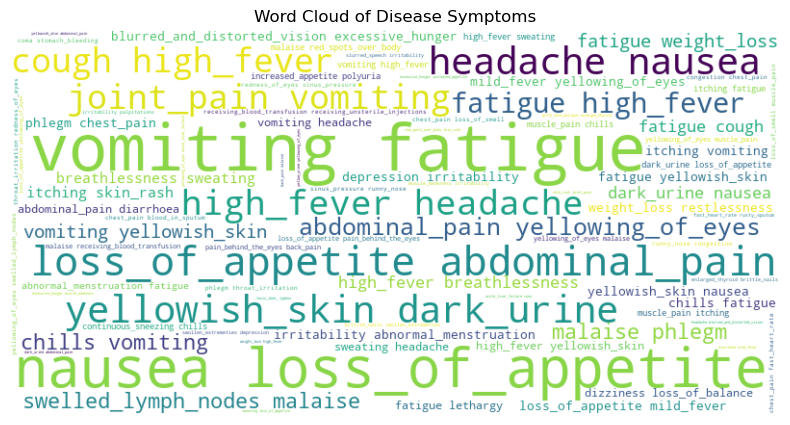

In [101]:
# Let's take this a step further and do a word cloud

from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_symptoms)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title("Word Cloud of Disease Symptoms")
plt.show()

## Convert text data to numerical form using TF-IDF

In [102]:
# Text data being unstructured cannot be directly processed by these clustering algorithms unless it is transformed into numerical format

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['combined_symptoms'])


## Model Generation

In [103]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage


model = AgglomerativeClustering(
    n_clusters=None,  # None means do not predefine the number of clusters
    distance_threshold=1.5,  # Set a threshold for merging clusters
    linkage='ward'
)
model.fit(tfidf_matrix.toarray())

AgglomerativeClustering(distance_threshold=1.5, n_clusters=None)

Now we will perform a simple hierarchical clustering to see how the patients separate from each other.

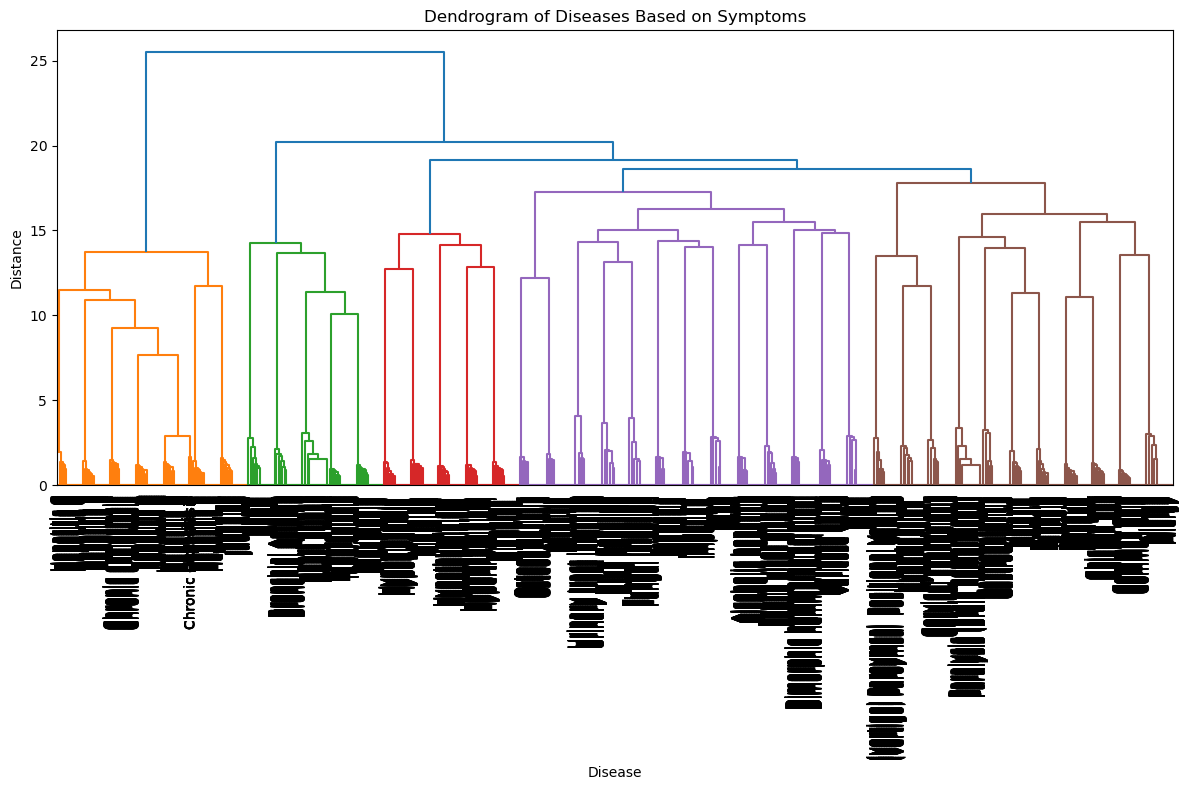

In [104]:
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=data['Disease'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Diseases Based on Symptoms")
plt.xlabel("Disease")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [105]:
# Sanity check and to put the clusters within the main table
data['Cluster'] = model.labels_
print(data[['Disease', 'Cluster']])

                                      Disease  Cluster
0                            Fungal infection       18
1                            Fungal infection      114
2                            Fungal infection       18
3                            Fungal infection       61
4                            Fungal infection       86
...                                       ...      ...
4915  (vertigo) Paroymsal  Positional Vertigo        5
4916                                     Acne       50
4917                  Urinary tract infection       30
4918                                Psoriasis       27
4919                                 Impetigo       19

[4920 rows x 2 columns]


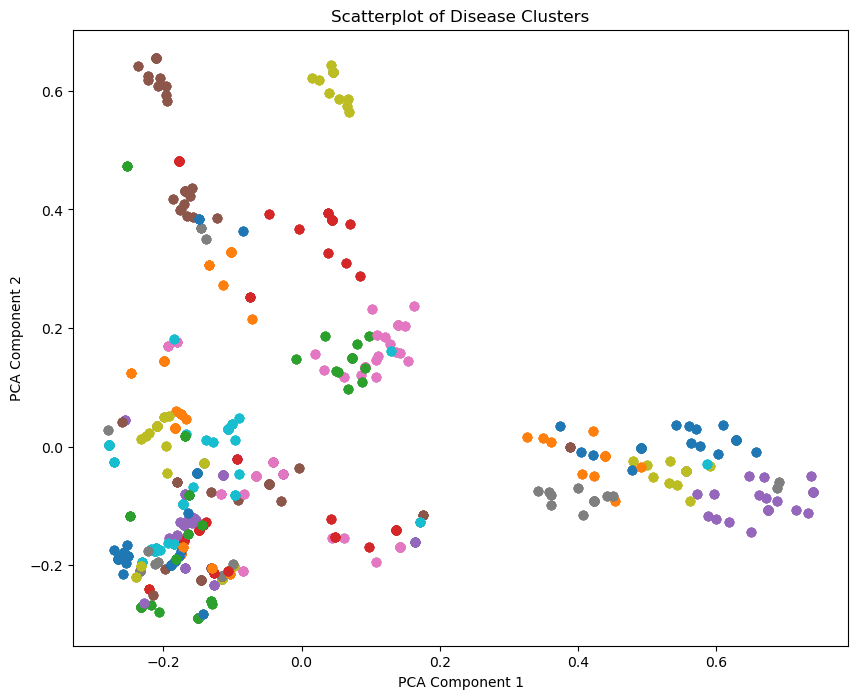

In [106]:
# The dendrogram is nice, but let's do a PCA that will show us a scatterplot of the disease clusters

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 8))
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = reduced_data[data['Cluster'] == cluster]
    plt.scatter(
        cluster_data[:, 0], cluster_data[:, 1],
        label=f'Cluster {cluster}', alpha=0.7
    )

plt.title("Scatterplot of Disease Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Model Refinement

This is a lot of clusters. You can kind of see the patterns if you look closely, but this is very noisy.  So let's see if we can reduce the number of clusters.

C:\Users\dvanbooven\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


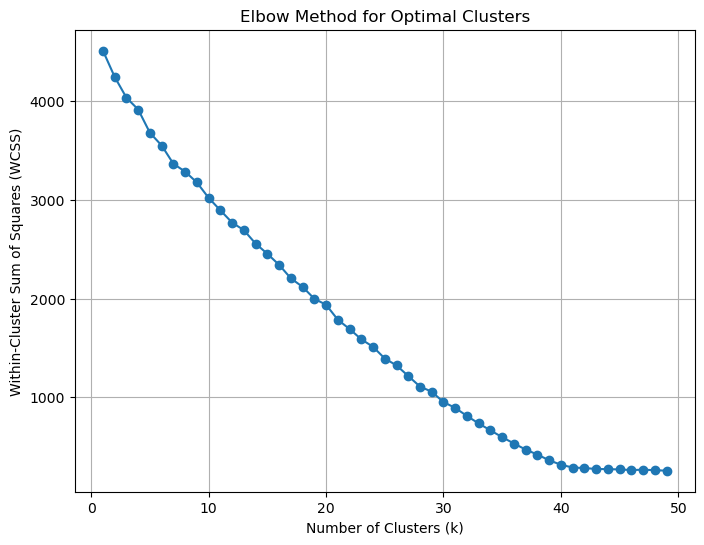

In [107]:
# Let's apply the elbow method to find the optimal number of clusters.

from sklearn.cluster import KMeans

wcss = []  # List to store WCSS for each k
k_values = range(1, 50)  # Number of clusters to try (1 to 50)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid()
plt.show()

In [108]:
# Find the max value of cluster...

n_clusters = len(set(data['Cluster']))  # Count unique cluster labels

print(f"Number of clusters found: {n_clusters}")

Number of clusters found: 116


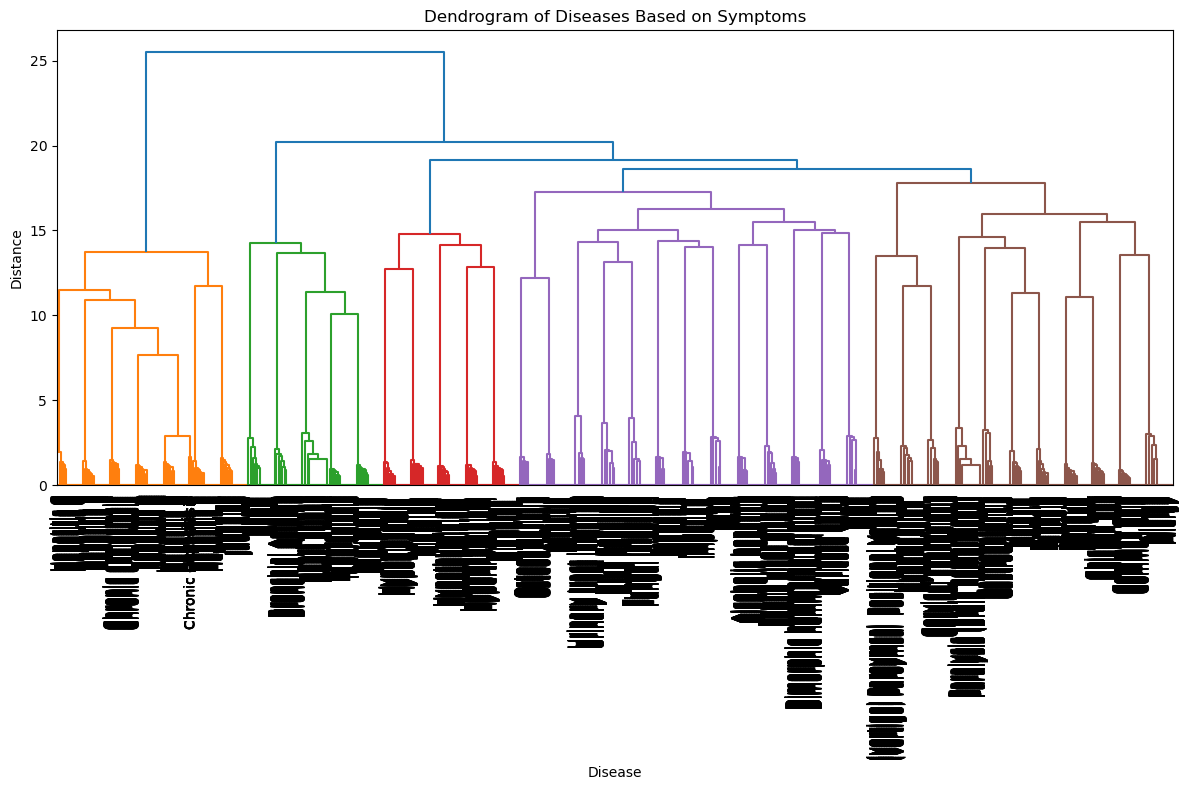

In [109]:
# Let's reduce the number of clusters from 116 to 40 and redo the agglomerativeclustering to see what that does to the analysis.

model = AgglomerativeClustering(
    n_clusters=40,  # None means do not predefine the number of clusters
    linkage='ward'
)

linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=data['Disease'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram of Diseases Based on Symptoms")
plt.xlabel("Disease")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [110]:
model.fit(tfidf_matrix.toarray())
data['Cluster'] = model.labels_
print(data[['Disease', 'Cluster']])

                                      Disease  Cluster
0                            Fungal infection        3
1                            Fungal infection        3
2                            Fungal infection        3
3                            Fungal infection        3
4                            Fungal infection        3
...                                       ...      ...
4915  (vertigo) Paroymsal  Positional Vertigo       12
4916                                     Acne        8
4917                  Urinary tract infection        1
4918                                Psoriasis       33
4919                                 Impetigo       21

[4920 rows x 2 columns]


The top 5 values for "fungal infection" now all appear to be headed towards cluster 3 which is a good sign

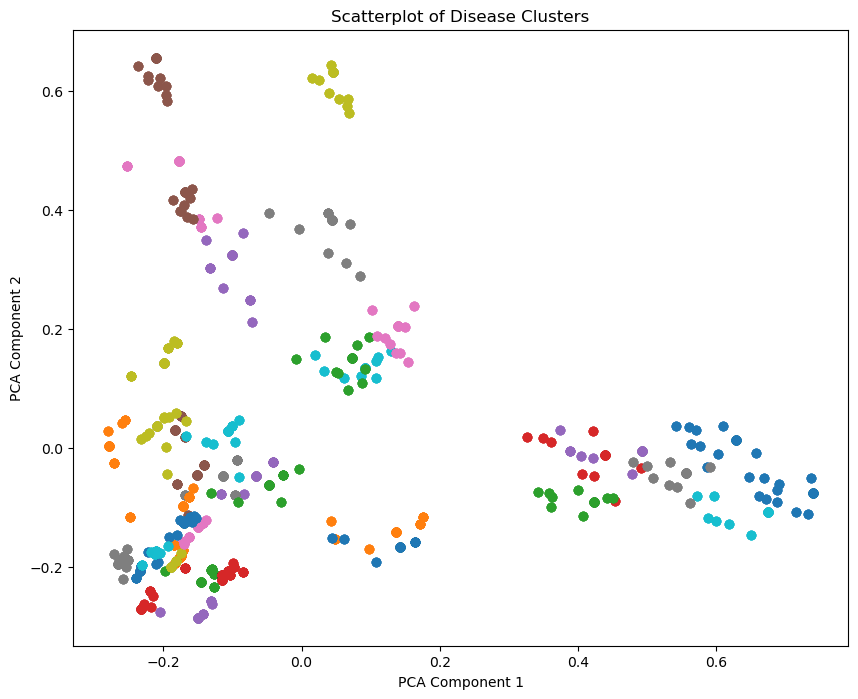

In [111]:
# Let's redo the scatterplot PCA to show the 40 cluster model
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(10, 8))
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = reduced_data[data['Cluster'] == cluster]
    plt.scatter(
        cluster_data[:, 0], cluster_data[:, 1],
        label=f'Cluster {cluster}', alpha=0.7
    )

plt.title("Scatterplot of Disease Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [112]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(tfidf_matrix.toarray())

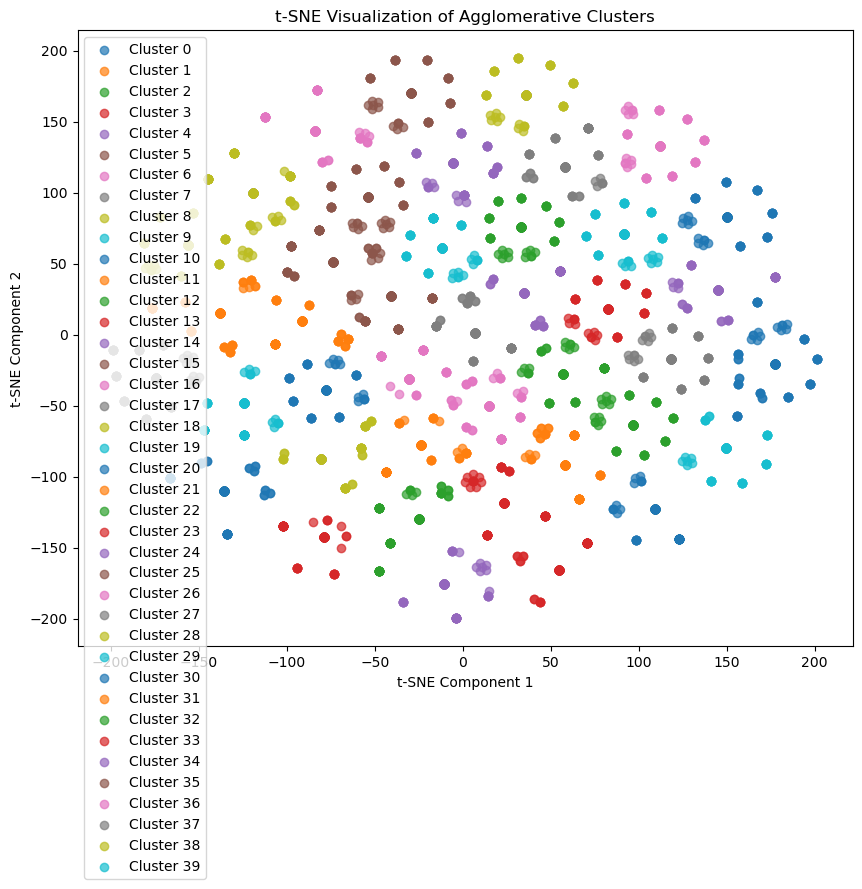

In [113]:
plt.figure(figsize=(10, 8))
for cluster in sorted(data['Cluster'].unique()):
    cluster_data = tsne_results[data['Cluster'] == cluster]
    plt.scatter(
        cluster_data[:, 0], cluster_data[:, 1],
        label=f'Cluster {cluster}', alpha=0.7
    )

plt.title("t-SNE Visualization of Agglomerative Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()


## Model Evaluation

In [114]:
# Let's look at silhouette scores

from sklearn.metrics import silhouette_score

# get model labels
labels = model.labels_

# Calculate silhouette score
score = silhouette_score(tfidf_matrix, labels)
print(f"Silhouette Score: {score}")

# Remember a silhouette score near 1 are well-separated and cohesive, near 0 is unclear, and -1 shows misassignment


Silhouette Score: 0.7698943712079074


In [115]:
import numpy as np

top_terms = {}

feature_names = np.array(vectorizer.get_feature_names_out())

for cluster in np.unique(labels):
    cluster_indices = np.where(labels == cluster)[0]
    cluster_data = tfidf_matrix[cluster_indices]
    avg_tfidf_per_term = cluster_data.mean(axis=0).A1
    top_terms[cluster] = feature_names[np.argsort(avg_tfidf_per_term)[::-1][:10]]  # Top 10 terms

# Display top terms for each cluster
for cluster, terms in top_terms.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: dark_urine, yellowing_of_eyes, joint_pain, yellowish_skin, abdominal_pain, nausea, loss_of_appetite, vomiting, mild_fever, muscle_pain
Cluster 1: bladder_discomfort, continuous_feel_of_urine, urine, foul_smell_of, burning_micturition, extra_marital_contacts, family_history, fast_heart_rate, fatigue, increased_appetite
Cluster 2: spotting_, urination, burning_micturition, stomach_pain, itching, skin_rash, family_history, foul_smell_of, fluid_overload, fatigue
Cluster 3: nodal_skin_eruptions, _patches, dischromic, itching, skin_rash, lethargy, high_fever, distention_of_abdomen, dizziness, drying_and_tingling_lips
Cluster 4: dehydration, sunken_eyes, diarrhoea, vomiting, dizziness, drying_and_tingling_lips, enlarged_thyroid, excessive_hunger, extra_marital_contacts, hip_joint_pain
Cluster 5: shivering, watering_from_eyes, continuous_sneezing, chills, fast_heart_rate, high_fever, headache, foul_smell_of, fluid_overload, fatigue
Cluster 6: swollen_legs, cramps, prominent_veins_on

In [116]:
# proof of concept, let's look at a cluster and see if we can determine what the disease was...

cluster_0_data = data[data['Cluster'] == 0]

# give me a unique set of diseases for this cluster 

print(data['Disease'].unique())

['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma' 'Hypertension ' 'Migraine' 'Cervical spondylosis'
 'Paralysis (brain hemorrhage)' 'Jaundice' 'Malaria' 'Chicken pox'
 'Dengue' 'Typhoid' 'hepatitis A' 'Hepatitis B' 'Hepatitis C'
 'Hepatitis D' 'Hepatitis E' 'Alcoholic hepatitis' 'Tuberculosis'
 'Common Cold' 'Pneumonia' 'Dimorphic hemmorhoids(piles)' 'Heart attack'
 'Varicose veins' 'Hypothyroidism' 'Hyperthyroidism' 'Hypoglycemia'
 'Osteoarthristis' 'Arthritis' '(vertigo) Paroymsal  Positional Vertigo'
 'Acne' 'Urinary tract infection' 'Psoriasis' 'Impetigo']
